In [27]:
import numpy as np 
import scipy.io as sio  
import os
import matplotlib.pyplot as plt 
import seaborn as sns  
from scipy.ndimage import gaussian_filter

# import smoothing # calcFRvsTime

## 0) Functions

In [38]:
def calcFRVsTime(cell_id,st,clu,opt = None):
    """
        Function to convert cell spike times into smoothed signal

        Arguments:
            cell_id: numpy array of cell ids to extract
            dat: dictionary loaded from processed neuropix struct
            opt: options for smoothing etc

    """
    if not opt:
        opt = dict(tbin =  0.02,
                   tstart = 0,
                   tend = np.max(st),
                   smoothSigma_time = 0.1)

    tbinedge = np.arange(opt['tstart'],opt['tend'],opt['tbin'])
    tbincent = tbinedge[:-1] + opt["tbin"] / 2

    # firing rate matrix
    fr = np.empty((len(cell_id),len(tbinedge)-1)) 
    fr[:] = np.nan

    for i, this_cell_id in enumerate(cell_id):
        # get spike times for this cell
        spike_t = st[clu == this_cell_id];
        spike_t = spike_t[(spike_t >= opt['tstart']) & (spike_t <= opt['tend'])];

        # compute distance-binned firing rate
        fr_this,edges = np.histogram(spike_t,bins = tbinedge)
        fr_this = fr_this / opt['tbin']

        # smooth firing rate
        fr_this = gaussian_filter(fr_this,sigma = opt['smoothSigma_time']/opt['tbin']);

        if len(np.where(np.isnan(fr_this))[0]) > 0:
            raise ValueError("NaN in firing rate")
        fr[i,:] = fr_this;

    return fr,tbincent

## 1) Loading firing rate matrices

In [44]:
mouse_dir = '/Users/joshstern/Documents/UchidaLab_NeuralData/processed_neuropix_data/80'   
data = dict()  
calcFR_opt = dict(tbin =  0.02,
                  tstart = 0,
                  smoothSigma_time = 0.1)  
tbin_ms = calcFR_opt['tbin'] * 1000

with os.scandir(mouse_dir) as it:
    for entry in it:
        if not entry.name.startswith('.') and entry.is_file():  
            # load in struct
            day_key = entry.name[:2] + entry.name[-7:-4]
            data[day_key] = sio.loadmat(entry.path)  
            
            # smooth firing rates 
            cgs = data[day_key]['sp']['cgs'][0][0] 
            cids = data[day_key]['sp']['cids'][0][0]
            good_cells = cids[cgs == 2]  
            st = data[day_key]['sp']['st'][0][0]  
            calcFR_opt['tend'] = np.max(st)
            clu = data[day_key]['sp']['clu'][0][0] 
            data[day_key]['fr_mat_full'],tbincent = calcFRVsTime(good_cells,st,clu,opt = calcFR_opt) 
            
            print("Finished loading %s"%entry.name)

Finished loading 80_20200315.mat
Finished loading 80_20200317.mat
Finished loading 80_20200316.mat


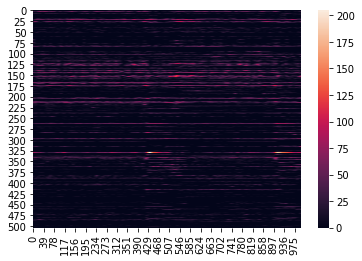

In [46]:
sns.heatmap(data[day_key]['fr_mat_full'][:,:1000])